In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

In [40]:
sp500_balance_df = pd.read_csv('alphaVantage_data/sp500_balance_2307.csv')
sp500_balance_df['fiscalDateEnding'] = pd.to_datetime(sp500_balance_df['fiscalDateEnding'])
sp500_balance_df.head()

,symbol,fiscalDateEnding,lineItem,value
0,MMM,2022-12-31,reportedCurrency,USD
1,MMM,2021-12-31,reportedCurrency,USD
2,MMM,2020-12-31,reportedCurrency,USD
3,MMM,2019-12-31,reportedCurrency,USD
4,MMM,2018-12-31,reportedCurrency,USD


In [41]:
def ticker_summary(ticker, df, line_items):
    filtered_df = df[df['symbol'] == ticker]
    sorted_df = filtered_df.sort_values('fiscalDateEnding', ascending=False)
    most_recent_balance_sheet = sorted_df[sorted_df['fiscalDateEnding'] == sorted_df['fiscalDateEnding'].iloc[0]]
    print(ticker)
    for line_item in line_items:
        formatted_value = "{:,}".format(int(most_recent_balance_sheet.loc[most_recent_balance_sheet['lineItem'] == line_item, 'value'].values[0]))
        print("{}: {}".format(line_item, formatted_value))
    
ticker_summary(ticker='AAPL', df = sp500_balance_df.copy(), line_items=['totalAssets', 'totalLiabilities', 'totalShareholderEquity'])

AAPL
totalAssets: 352,755,000,000
totalLiabilities: 302,083,000,000
totalShareholderEquity: 50,672,000,000


In [42]:
def index_summary(df, line_items):
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df_filtered = df[df['lineItem'].isin(line_items)]
    # Sort by date and keep the most recent record for each symbol and line item
    df_filtered = df_filtered.sort_values('fiscalDateEnding').groupby(['symbol', 'lineItem']).last().reset_index()
    # Pivot the data to wide format
    df_pivot = df_filtered.pivot(index='symbol', columns='lineItem', values='value').reset_index()
    
    # Calculate summary statistics for the three line items
    summary_stats = df_pivot[line_items].describe()
    # Convert to a more readable format
    summary_stats = summary_stats.apply(lambda x: round(x, 2)).T

    return df_pivot, summary_stats

df_pivot, summary_stats = index_summary(sp500_balance_df.copy(), ['totalAssets', 'totalLiabilities', 'totalShareholderEquity'])
summary_stats

,count,mean,std,min,25%,50%,75%,max
lineItem,,,,,,,,
totalAssets,497.0,8.614823e+10,2.778776e+11,1.442034e+09,1.231400e+10,2.618274e+10,6.317100e+10,3.665743e+12
totalLiabilities,497.0,6.856878e+10,2.536156e+11,3.902830e+08,7.053200e+09,1.592840e+10,4.233600e+10,3.373411e+12
totalShareholderEquity,497.0,1.743507e+10,3.258994e+10,-1.588300e+10,3.360751e+09,7.948000e+09,1.842800e+10,2.923320e+11


**Total Assets:**
- **Mean:** $86,148,230,000
- **Median:** $26,182,740,000
- **Minimum:** $1,442,034,000
- **Maximum:** $3,665,743,000,000

**Total Liabilities:**
- **Mean:** $68,568,780,000
- **Median:** $15,928,400,000
- **Minimum:** $390,283,000
- **Maximum:** $3,373,411,000,000

**Total Shareholder Equity:**
- **Mean:** $17,435,070,000
- **Median:** $7,948,000,000
- **Minimum:** -$15,883,000,000 (negative shareholder equity indicates liabilities exceed assets)
- **Maximum:** $292,332,000,000


The wide range of these line items across companies indicates substantial variability in the size and financial structure of S&P 500 companies. The mean values are significantly larger than the median values, suggesting the presence of a few very large companies that are pulling up the average.

In [43]:
def index_lineItem_plot(df, x, y, hover_data = ['symbol']):
    fig = px.scatter(df,
                x=x, 
                y=y,
                hover_data=hover_data)

    fig.update_layout(
        title=f'{x} vs {y}',
        xaxis=dict(title=f'{x}'),
        yaxis=dict(title=f'{y}'),
        hovermode="closest"
    )

    fig.show()
    
index_lineItem_plot(df = df_pivot.copy(), x='totalAssets', y='totalShareholderEquity', hover_data=['symbol', 'totalLiabilities'])

In [44]:
df_pivot.nlargest(10, 'totalShareholderEquity')

lineItem,symbol,totalAssets,totalLiabilities,totalShareholderEquity
254,JPM,3.665743e+12,3.373411e+12,2.923320e+11
54,BAC,3.051375e+12,2.778178e+12,2.731970e+11
204,GOOGL,3.652640e+11,1.091200e+11,2.561440e+11
74,C,2.416676e+12,2.214838e+12,2.011890e+11
489,XOM,3.690670e+11,1.665940e+11,1.950490e+11
477,WFC,1.881020e+12,1.698807e+12,1.802270e+11
315,MSFT,3.648400e+11,1.982980e+11,1.665420e+11
124,CVX,2.577090e+11,9.746700e+10,1.592820e+11
34,AMZN,4.626750e+11,3.166320e+11,1.460430e+11
296,META,1.857270e+11,6.001400e+10,1.257130e+11


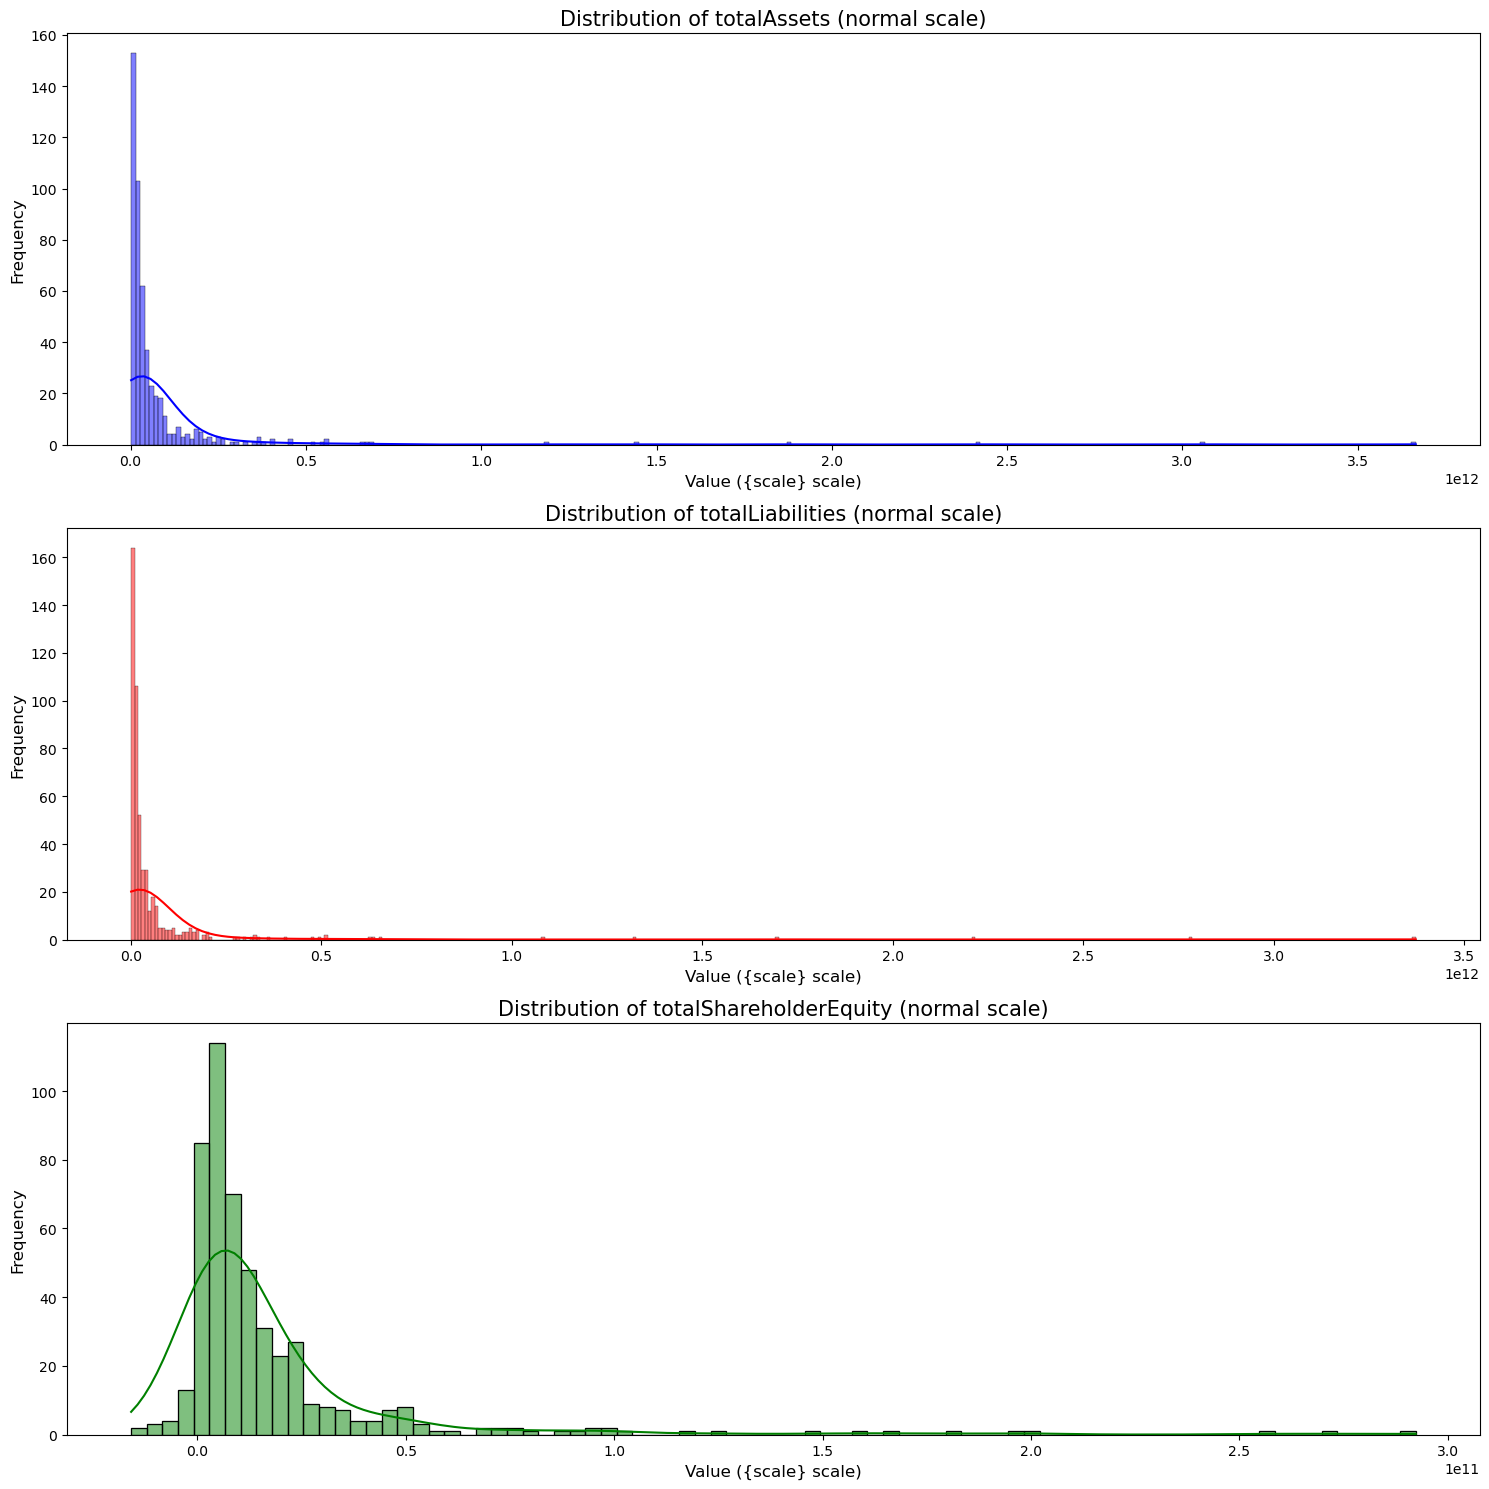

In [45]:
def plot_hist(df, line_items, scale='normal'):

    fig, axes = plt.subplots(len(line_items), 1, figsize=(15, 15))

    for ax, (line_item, color) in zip(axes.flatten(), line_items):
        if scale == 'normal':
            sns.histplot(data=df, x=line_item, ax=ax, color=color, kde=True)
            ax.set_title(f'Distribution of {line_item} ({scale} scale)', fontsize=15)
            ax.set_xlabel('Value ({scale} scale)', fontsize=12)
        elif scale == 'log':
            sns.histplot(data=df, x=line_item, ax=ax, color=color, kde=True, log_scale=True)
            ax.set_title(f'Distribution of {line_item} (normal {scale})', fontsize=15)
            ax.set_xlabel('Value (normal {scale})', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)

    plt.tight_layout()
    plt.show()
    
plot_hist(df = df_pivot.copy(), line_items = [('totalAssets', 'blue'), ('totalLiabilities', 'red'), ('totalShareholderEquity', 'green')])

The histograms above show the distributions of total assets, total liabilities, and total shareholder equity for the S&P 500 companies on a normal (linear) scale.

- Total Assets: Most companies have total assets in the range of 0 to 1 trillion dollars. However, a few companies have significantly higher total assets, which appear as a long tail on the right side of the distribution.

- Total Liabilities: Similarly, most companies have total liabilities in the range of 0 to 1 trillion dollars. Again, there are a few companies with significantly higher total liabilities.

- Total Shareholder Equity: The distribution of total shareholder equity appears more concentrated than the other two, with most values in the range of 0 to 50 billion dollars. There are a few companies with negative shareholder equity, indicating that their liabilities exceed their assets.

The normal scale plots show that the distributions are skewed with a long tail to the right, indicating the presence of a few companies with exceptionally high values. However, the exact values for these outliers are hard to distinguish due to the wide range of the data. This is why a log scale is often used when visualizing such data.

c:\Users\grant\anaconda3\envs\fin\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning:

invalid value encountered in log10



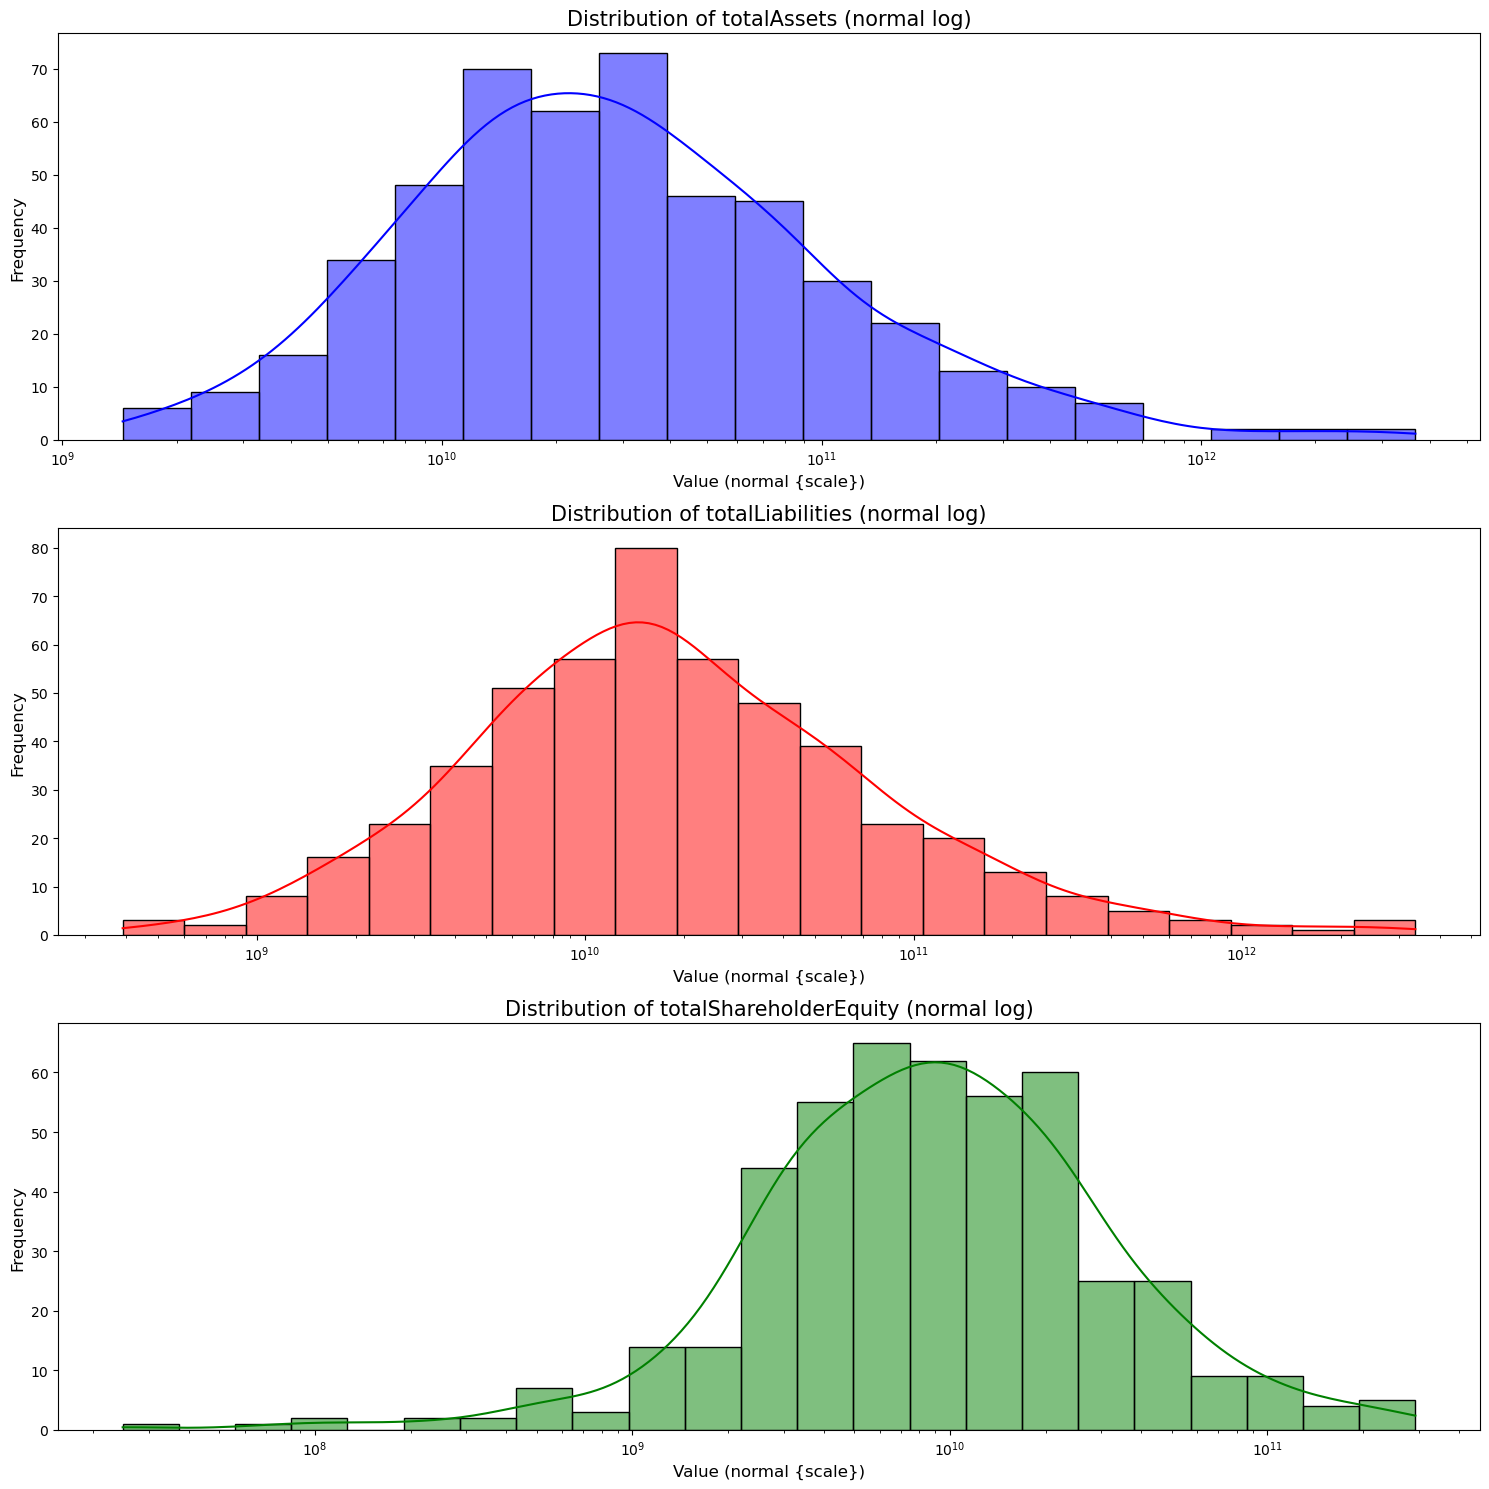

In [46]:
plot_hist(df = df_pivot.copy(), line_items = [('totalAssets', 'blue'), ('totalLiabilities', 'red'), ('totalShareholderEquity', 'green')], scale='log')

The histograms above show the distributions of total assets, total liabilities, and total shareholder equity for the S&P 500 companies on a log scale.

- Total Assets: Most companies have total assets in the range of 10 billion to 100 billion dollars. There are a few companies with assets over 1 trillion dollars, which can be considered outliers.

- Total Liabilities: Similar to total assets, most companies have total liabilities in the range of 1 billion to 100 billion dollars. There are a few companies with exceptionally high liabilities.

- Total Shareholder Equity: The distribution of total shareholder equity is more concentrated than the other two distributions, with most values between 1 billion and 10 billion dollars. There are a few companies with negative shareholder equity, indicating that their liabilities exceed their assets.

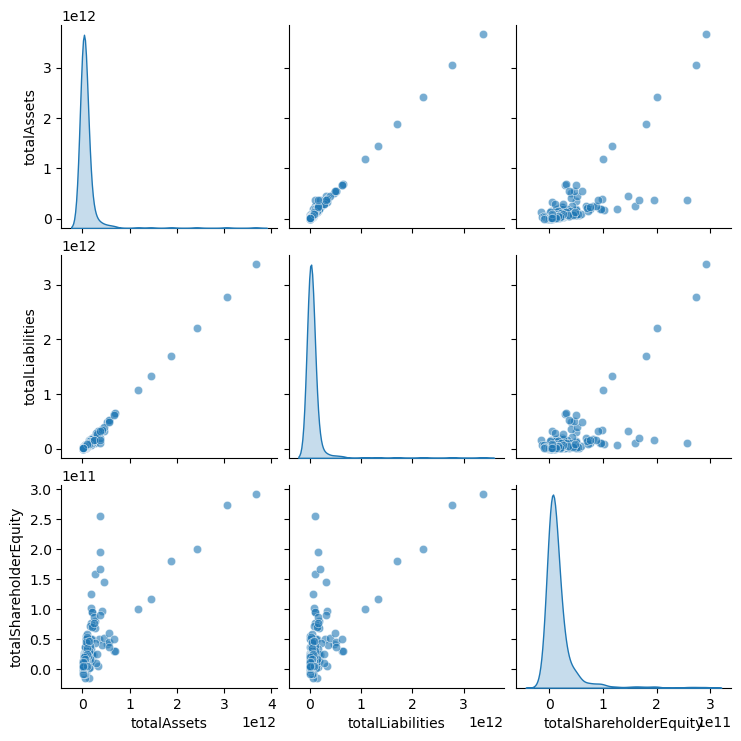

In [47]:
# Create a scatter plot matrix to visualize the relationships between the three line items
sns.pairplot(df_pivot[['totalAssets', 'totalLiabilities', 'totalShareholderEquity']].dropna(), diag_kind='kde', plot_kws={'alpha': 0.6})

plt.show()

The scatterplot matrix above shows the pairwise relationships between total assets, total liabilities, and total shareholder equity. The diagonal plots show the distribution of each variable, while the off-diagonal plots show the scatterplot between each pair of variables.

A few observations:

- Total Assets and Total Liabilities: There appears to be a strong positive relationship between total assets and total liabilities. This makes sense, as larger companies will generally have both larger assets and larger liabilities.

- Total Assets and Total Shareholder Equity: There is also a positive relationship between total assets and total shareholder equity, although it seems less strong and more scattered than the relationship between total assets and total liabilities.

- Total Liabilities and Total Shareholder Equity: The relationship between total liabilities and total shareholder equity seems to be quite scattered, with no clear trend. This suggests that the balance between liabilities and equity can vary widely among companies, reflecting differences in their capital structure.

In general, these scatterplots show that while there are some trends in the relationships between assets, liabilities, and equity, there is also a significant amount of variation. This highlights the diversity of financial structures among S&P 500 companies.

In [48]:
sp500_income_df = pd.read_csv('alphaVantage_data/sp500_income_2307.csv')
sp500_income_df['fiscalDateEnding'] = pd.to_datetime(sp500_income_df['fiscalDateEnding'])
sp500_income_df.head()

income_line_items = ['totalRevenue', 'netIncome']

In [49]:
def ticker_summary(ticker, df, line_items):
    filtered_df = df[df['symbol'] == ticker]
    sorted_df = filtered_df.sort_values('fiscalDateEnding', ascending=False)
    most_recent_balance_sheet = sorted_df[sorted_df['fiscalDateEnding'] == sorted_df['fiscalDateEnding'].iloc[0]]
    print(ticker)
    for line_item in line_items:
        formatted_value = "{:,}".format(int(most_recent_balance_sheet.loc[most_recent_balance_sheet['lineItem'] == line_item, 'value'].values[0]))
        print("{}: {}".format(line_item, formatted_value))
    
ticker_summary(ticker='AAPL', df = sp500_income_df.copy(), line_items=income_line_items)

AAPL
totalRevenue: 391,397,000,000
netIncome: 99,803,000,000


In [50]:
df_pivot, summary_stats = index_summary(sp500_income_df.copy(), line_items=income_line_items)
summary_stats

,count,mean,std,min,25%,50%,75%,max
lineItem,,,,,,,,
totalRevenue,497.0,3.136217e+10,6.057540e+10,9.780000e+06,5.709200e+09,1.262300e+10,2.751800e+10,6.112890e+11
netIncome,497.0,3.225716e+09,7.894702e+09,-1.672000e+10,6.230000e+08,1.315605e+09,3.248000e+09,9.980300e+10


In [51]:
index_lineItem_plot(df = df_pivot.copy(), x='totalRevenue', y='netIncome', hover_data=['symbol'])

In [52]:
df_pivot.nlargest(10, 'netIncome')

lineItem,symbol,netIncome,totalRevenue
3,AAPL,9.980300e+10,3.913970e+11
315,MSFT,7.273800e+10,1.961090e+11
204,GOOGL,5.997200e+10,2.812790e+11
489,XOM,5.574000e+10,4.136800e+11
254,JPM,3.767600e+10,1.286950e+11
124,CVX,3.546500e+10,2.462520e+11
360,PFE,3.137200e+10,1.003300e+11
54,BAC,2.752800e+10,9.495000e+10
296,META,2.320000e+10,1.163520e+11
469,VZ,2.125600e+10,1.368350e+11


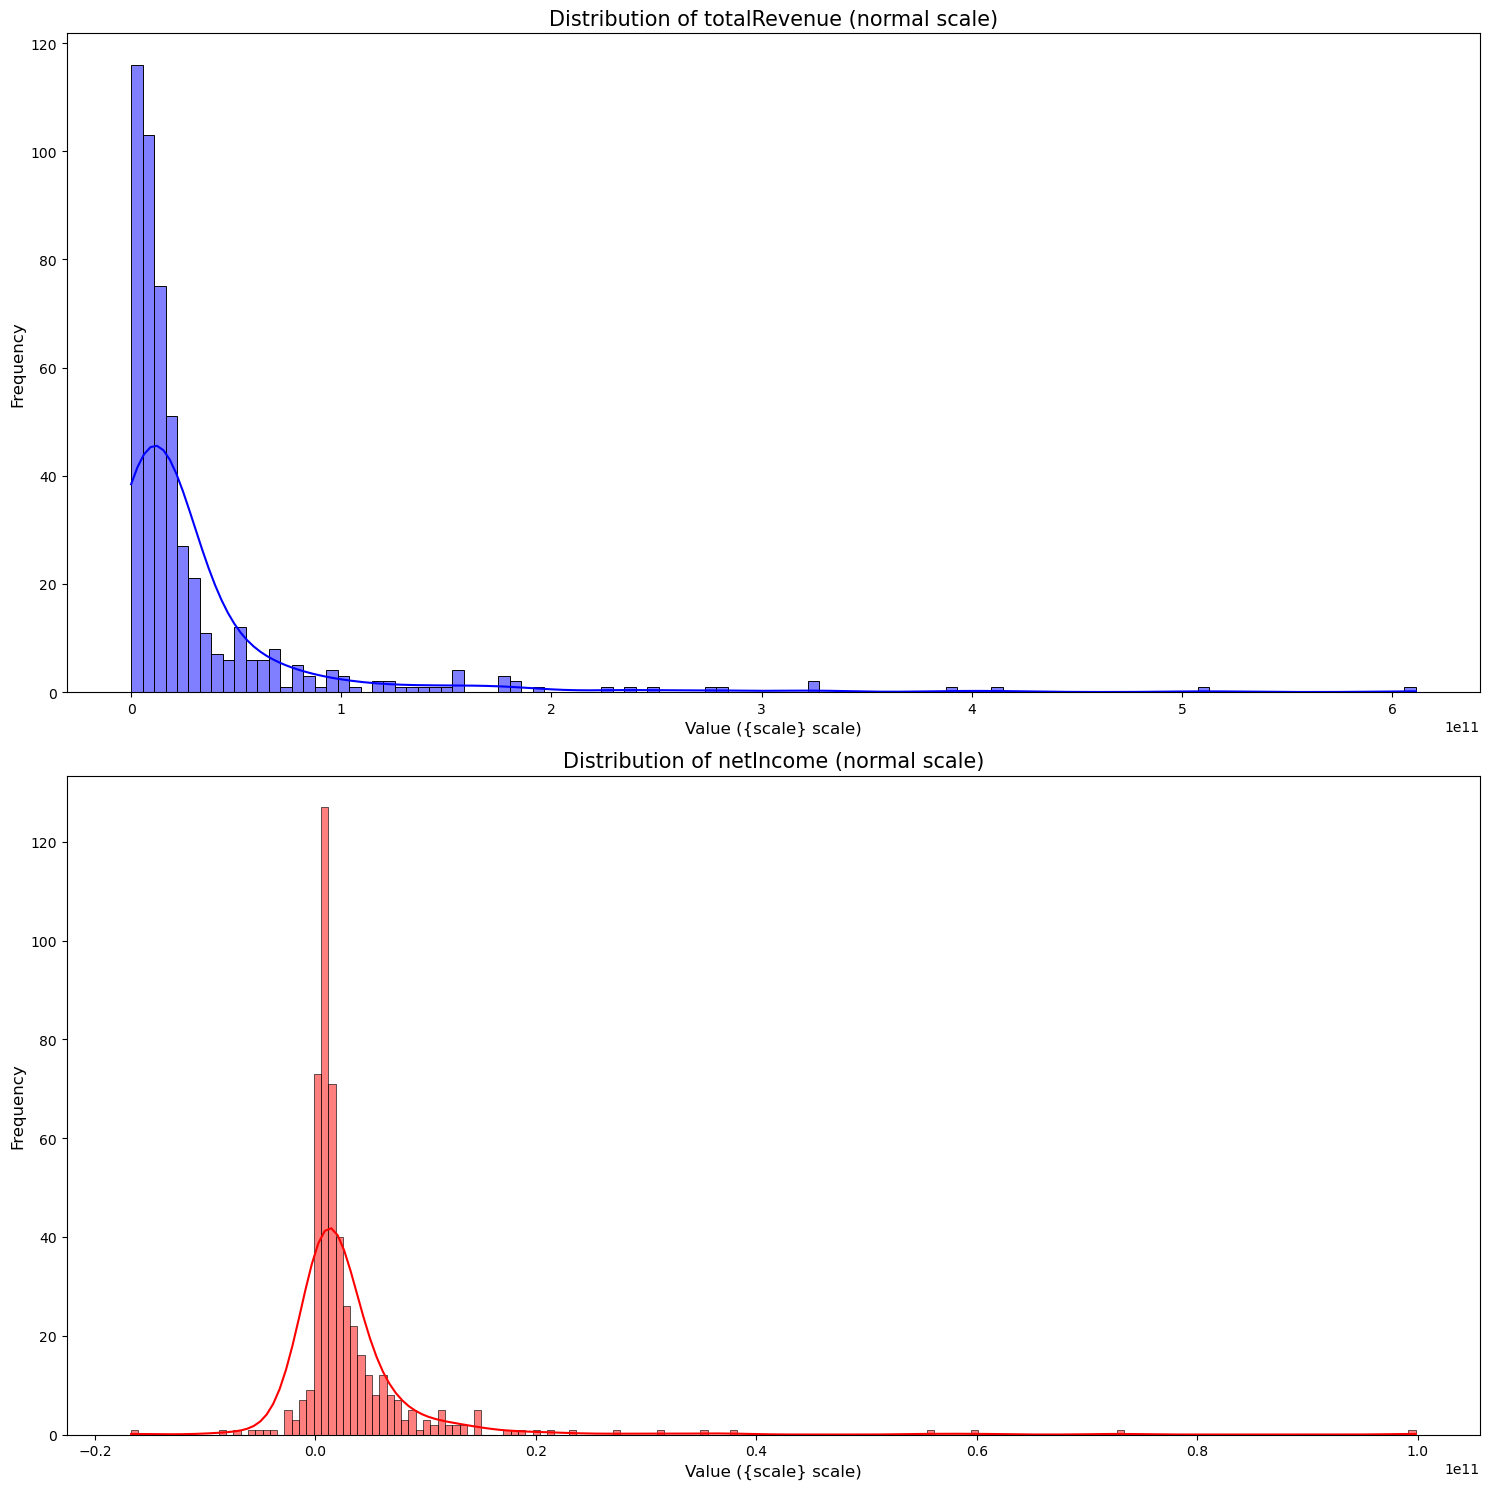

In [53]:
plot_hist(df = df_pivot.copy(), line_items = [('totalRevenue', 'blue'), ('netIncome', 'red')])

c:\Users\grant\anaconda3\envs\fin\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning:

invalid value encountered in log10



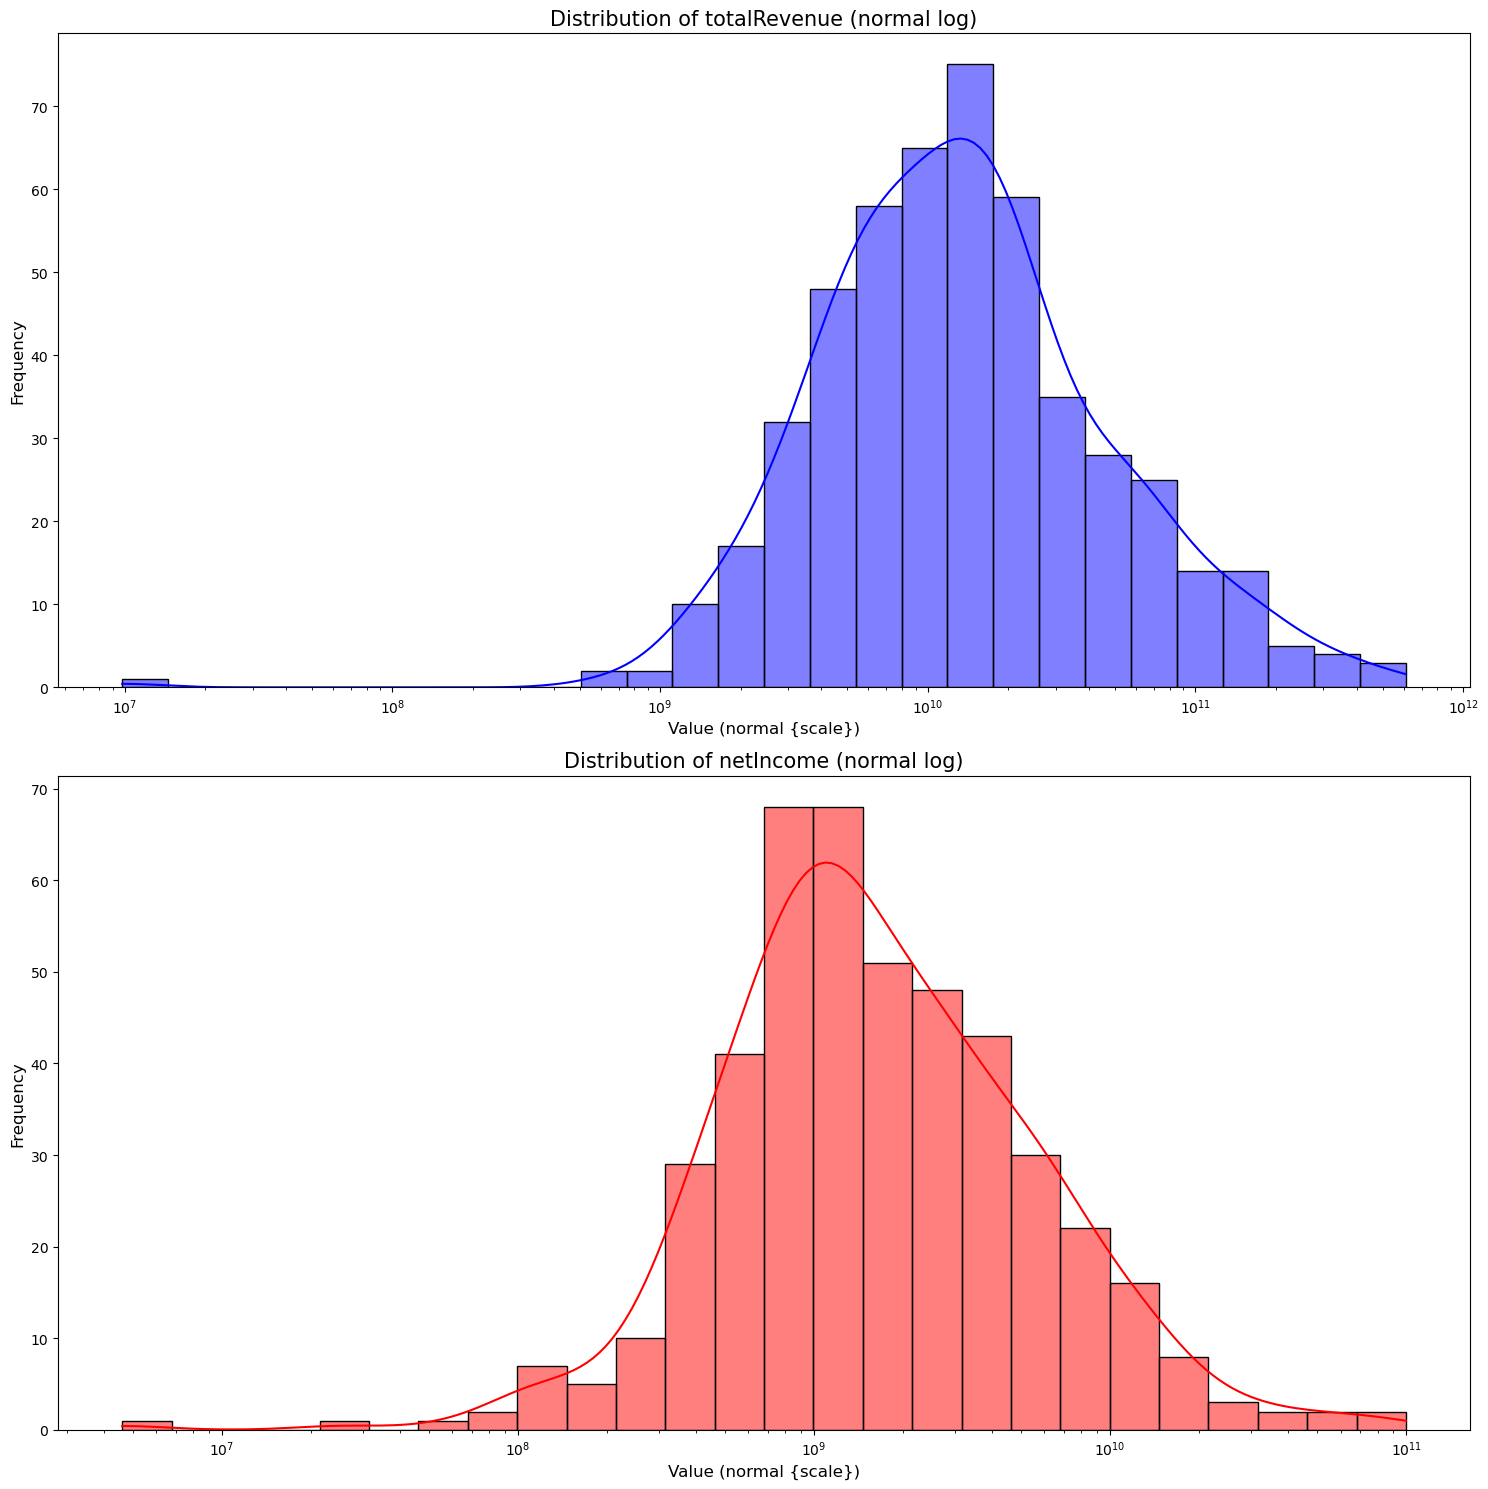

In [54]:
plot_hist(df = df_pivot.copy(), line_items = [('totalRevenue', 'blue'), ('netIncome', 'red')], scale='log')

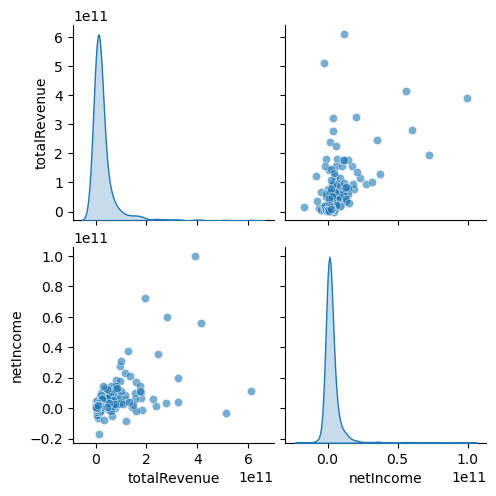

In [55]:
sns.pairplot(df_pivot[income_line_items].dropna(), diag_kind='kde', plot_kws={'alpha': 0.6})
plt.show()

Ratio Analysis

In [88]:
inc_df = pd.read_csv('alphaVantage_data/sp500_income_2307.csv')
inc_df['value'] = pd.to_numeric(inc_df['value'], errors='coerce')
inc_df['fiscalDateEnding'] = pd.to_datetime(inc_df['fiscalDateEnding'])
inc_df['end_of_month'] = inc_df['fiscalDateEnding'] + pd.offsets.MonthEnd(0)
inc_df.drop('fiscalDateEnding', axis=1, inplace=True)
inc_df.set_index(['symbol', 'end_of_month'], inplace=True)

bal_df = pd.read_csv('alphaVantage_data/sp500_balance_2307.csv')
bal_df['value'] = pd.to_numeric(bal_df['value'], errors='coerce')
bal_df['fiscalDateEnding'] = pd.to_datetime(bal_df['fiscalDateEnding'])
bal_df['end_of_month'] = bal_df['fiscalDateEnding'] + pd.offsets.MonthEnd(0)
bal_df.drop('fiscalDateEnding', axis=1, inplace=True)
bal_df.set_index(['symbol', 'end_of_month'], inplace=True)

cash_df = pd.read_csv('alphaVantage_data/sp500_cash_2307.csv')
cash_df['value'] = pd.to_numeric(cash_df['value'], errors='coerce')
cash_df['fiscalDateEnding'] = pd.to_datetime(cash_df['fiscalDateEnding'])
cash_df['end_of_month'] = cash_df['fiscalDateEnding'] + pd.offsets.MonthEnd(0)
cash_df.drop('fiscalDateEnding', axis=1, inplace=True)
cash_df.set_index(['symbol', 'end_of_month'], inplace=True)

close_cols = ['symbol', 'end_of_month', 'close']
close_df = pd.read_csv('alphaVantage_data/sp500_monthlyAdj_2307.csv')
close_df['close'] = pd.to_numeric(close_df['close'], errors='coerce')
close_df['date'] = pd.to_datetime(close_df['date'])
close_df['end_of_month'] = close_df['date'].dt.to_period('M').dt.to_timestamp('M')
close_df = close_df[close_cols]
close_df.set_index(['symbol', 'end_of_month'], inplace=True)

earn_cols = ['symbol', 'year', 'reportedEPS']
earn_df = pd.read_csv('alphaVantage_data/sp500_earnings_2307.csv')
earn_df['reportedEPS'] = pd.to_numeric(earn_df['reportedEPS'], errors='coerce')
earn_df = earn_df[earn_df['sub_type'] == 'annualEarnings']
earn_df['fiscalDateEnding'] = pd.to_datetime(earn_df['fiscalDateEnding'])
earn_df['year'] = earn_df['fiscalDateEnding'].dt.year
earn_df = earn_df[earn_cols]
earn_df = earn_df.groupby(['symbol', 'year']).last().reset_index()

overview_cols = ['symbol', 'sector', 'industry']
overview_df = pd.read_csv('alphaVantage_data/sp500_overview_2307.csv')
overview_df.columns = [col.lower() for col in overview_df.columns]
overview_df['sector'] = overview_df['sector'].str.lower()
overview_df['industry'] = overview_df['industry'].str.lower()
overview_df = overview_df[overview_cols]

inc_cols = ['totalRevenue', 'operatingIncome', 'netIncome']
inc_pivot = inc_df[inc_df['lineItem'].isin(inc_cols)]
# # can't do the below method because a few companies have duplicate balance sheet entries, can check withb below code
# # duplicates_with_lineitem = bal_df.reset_index().duplicated(subset=['symbol', 'end_of_month', 'lineItem'])
# # num_duplicates_with_lineitem = duplicates_with_lineitem.sum()
# # num_duplicates_with_lineitem
# # duplicate_rows = bal_df.reset_index()[duplicates_with_lineitem]
# # duplicate_rows
# inc_pivot = inc_df.reset_index().pivot(index=['symbol', 'end_of_month'], columns='lineItem', values='value')
inc_pivot = inc_pivot.reset_index().pivot_table(index=['symbol', 'end_of_month'], columns='lineItem', values='value', aggfunc='mean')

# don't need to include ['symbol', 'fiscalDateEnding'] because they are the index
bal_cols = ['totalAssets', 'totalLiabilities', 'totalShareholderEquity'
            , 'totalCurrentAssets', 'totalCurrentLiabilities'
            , 'commonStockSharesOutstanding'
            , 'currentDebt', 'longTermDebt'
            , 'inventory']
bal_pivot = bal_df[bal_df['lineItem'].isin(bal_cols)]
bal_pivot = bal_pivot.reset_index().pivot_table(index=['symbol', 'end_of_month'], columns='lineItem', values='value', aggfunc='mean')

cash_cols = ['cashflowFromFinancing', 'cashflowFromInvestment', 'operatingCashflow'
            , 'capitalExpenditures']
cash_pivot = cash_df[cash_df['lineItem'].isin(cash_cols)]
cash_pivot = cash_pivot.reset_index().pivot_table(index=['symbol', 'end_of_month'], columns='lineItem', values='value', aggfunc='mean')

df = inc_pivot.join(bal_pivot, how='left')
df = df.join(cash_pivot, how='left')
df = df.join(close_df, how='left')
# # remove the few rows that have issues joining commonStockSharesOutstanding 
# print(df[df.isna().any(axis=1)])
df.dropna(inplace=True)
df.reset_index(inplace=True)
df['year'] = df['end_of_month'].dt.year
df = pd.merge(df, earn_df, on=['symbol', 'year'], how='left')
df = pd.merge(df, overview_df, on='symbol', how='left')
df.drop('year', axis=1, inplace=True)
df.set_index(['symbol', 'end_of_month'], inplace=True)

print(len(df))
df['price_to_earnings'] = df['close'] / df['reportedEPS']
df['price_to_earnings_2'] = (df['commonStockSharesOutstanding'] * df['close']) / (df['netIncome'])
df['debt_to_equity'] = df['totalLiabilities'] / df['totalShareholderEquity']
"""The Debt to Equity Ratio is typically calculated using total liabilities (both short-term and long-term) in the numerator, and total equity in the denominator (above).
The Debt to Equity Ratio is typically calculated using total liabilities (both short-term and long-term) in the numerator, and total equity in the denominator. (below) closer to what's on yahoo finance and morningstar"""
df['debt_to_equity_2'] = (df['currentDebt'] + df['longTermDebt']) / df['totalShareholderEquity']
df['return_on_equity'] = df['netIncome'] / df['totalShareholderEquity']
df['current_ratio'] = df['totalCurrentAssets'] / df['totalCurrentLiabilities']
df['quick_ratio'] = (df['totalCurrentAssets'] - df['inventory']) / df['totalCurrentLiabilities']
df['price_to_sales'] = (df['commonStockSharesOutstanding'] * df['close']) / df['totalRevenue']
df['price_to_book'] = (df['commonStockSharesOutstanding'] * df['close']) / df['totalShareholderEquity']
df['free_cash_flow'] = df['operatingCashflow'] - df['capitalExpenditures']

df.dropna(inplace=True)
print(len(df))
df.to_csv('sp500.csv')
df

1687
1687


netIncome  operatingIncome  totalRevenue  \
symbol end_of_month                                                
A      2019-10-31    1.071000e+09     9.410000e+08  5.073000e+09   
       2020-10-31    7.190000e+08     8.460000e+08  5.271000e+09   
       2021-10-31    1.210000e+09     1.347000e+09  6.236000e+09   
       2022-10-31    1.254000e+09     1.618000e+09  6.774000e+09   
AAL    2018-12-31    1.412000e+09     2.656000e+09  4.343000e+10   
...                           ...              ...           ...   
ZTS    2018-12-31    1.428000e+09     6.000000e+07  5.825000e+09   
       2019-12-31    1.500000e+09    -8.500000e+07  6.260000e+09   
       2020-12-31    1.638000e+09     1.240000e+08  6.675000e+09   
       2021-12-31    2.037000e+09     3.920000e+08  7.776000e+09   
       2022-12-31    2.114000e+09     5.650000e+08  8.080000e+09   

                     commonStockSharesOutstanding   currentDebt     inventory  \
symbol end_of_month                                                             
A      2019-10-31                     309000000.0  6.160000e+08  6.790000e+08   
       2020-10-31                     306000000.0  7.500000e+07  7.200000e+08   
       2021-10-31                     302000000.0  0.000000e+00  8.300000e+08   
       2022-10-31                     295000000.0  3.600000e+07  1.038000e+09   
AAL    2018-12-31                     460610870.0  3.294000e+09  1.522000e+09   
...                                           ...           ...           ...   
ZTS    2018-12-31                     479562326.0  9.000000e+06  1.391000e+09   
       2019-12-31                     475528210.0  5.000000e+08  1.410000e+09   
       2020-12-31                     475317751.0  6.440000e+08  1.628000e+09   
       2021-12-31                     472574090.0  0.000000e+00  1.923000e+09   
       2022-12-31                     463808059.0  1.352000e+09  2.345000e+09   

                     longTermDebt   totalAssets  totalCurrentAssets  \
symbol end_of_month                                                   
A      2019-10-31    1.786000e+09  9.452000e+09        3.189000e+09   
       2020-10-31    2.284000e+09  9.627000e+09        3.415000e+09   
       2021-10-31    2.729000e+09  1.070500e+10        3.799000e+09   
       2022-10-31    2.733000e+09  1.053200e+10        3.778000e+09   
AAL    2018-12-31    2.056600e+10  6.058000e+10        8.637000e+09   
...                           ...           ...                 ...   
ZTS    2018-12-31    7.657000e+09  1.077700e+10        4.399000e+09   
       2019-12-31    9.001000e+09  1.154500e+10        4.748000e+09   
       2020-12-31    9.270000e+09  1.360000e+10        6.611000e+09   
       2021-12-31    8.810000e+09  1.390000e+10        6.930000e+09   
       2022-12-31    1.151600e+10  1.492500e+10        7.506000e+09   

                     totalCurrentLiabilities  ...  price_to_earnings  \
symbol end_of_month                           ...                      
A      2019-10-31               2.080000e+09  ...          24.278846   
       2020-10-31               1.467000e+09  ...          31.125000   
       2021-10-31               1.708000e+09  ...          36.288018   
       2022-10-31               1.861000e+09  ...          26.554702   
AAL    2018-12-31               1.809600e+10  ...           7.057143   
...                                      ...  ...                ...   
ZTS    2018-12-31               1.223000e+09  ...          27.242038   
       2019-12-31               1.806000e+09  ...          36.359890   
       2020-12-31               2.170000e+09  ...          42.987013   
       2021-12-31               1.797000e+09  ...          51.921277   
       2022-12-31               3.167000e+09  ...          30.030738   

                     price_to_earnings_2  debt_to_equity  debt_to_equity_2  \
symbol end_of_month                                                          
A      2019-10-31              21.855042        0.990733          0.

In [57]:
# use https://www.morningstar.com/stocks/xnas/aapl/valuation and below to validate the metrics.
df.loc['AAPL', '2022-09-30']

netIncome                              99803000000.0
operatingIncome                       119437000000.0
totalRevenue                          391397000000.0
commonStockSharesOutstanding           15943425000.0
currentDebt                            21239000000.0
inventory                               4946000000.0
longTermDebt                          110100000000.0
totalAssets                           352755000000.0
totalCurrentAssets                    135405000000.0
totalCurrentLiabilities               153982000000.0
totalLiabilities                      302083000000.0
totalShareholderEquity                 50672000000.0
capitalExpenditures                    10708000000.0
cashflowFromFinancing                -110749000000.0
cashflowFromInvestment                -22354000000.0
operatingCashflow                     122151000000.0
close                                          138.2
reportedEPS                                     6.11
sector                                    tech

In [58]:
def index_metric_barChart(df, metric):
    df['year'] = df['end_of_month'].dt.year

    avg_pe_by_year = df.groupby('year')[metric].mean()

    ax = avg_pe_by_year.plot(kind='bar', xlabel='Year', ylabel=f'Average {metric} Ratio', title=f'S&P Average {metric} Ratio by Year')
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))

    plt.show()
    
def index_metric_summary(df, metric, relevant_cols, x, hoover_data, outlier_count = 10):
    index_metric_barChart(df.reset_index(), metric)
    most_recent_df = df.groupby(level=0).last().reset_index()
    print(f'largest {outlier_count}')
    print(most_recent_df[['symbol'] + relevant_cols + [metric]].nlargest(outlier_count, metric))
    print(f'smallest {outlier_count}')
    print(most_recent_df[['symbol'] + relevant_cols + [metric]].nsmallest(outlier_count, metric))
    index_lineItem_plot(df = most_recent_df.copy(), x=x, y=metric, hover_data=['symbol'] + hoover_data)

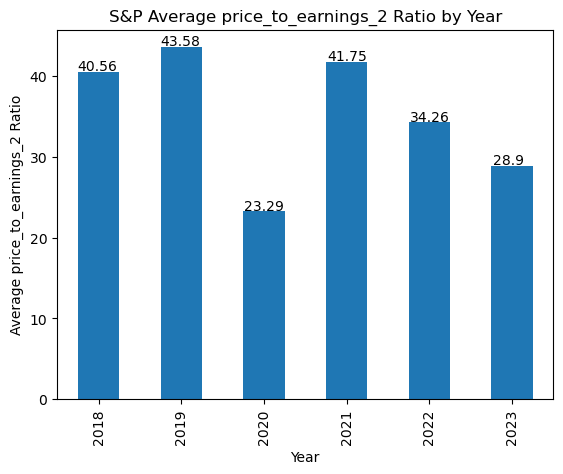

largest 10
    symbol    netIncome  commonStockSharesOutstanding   close  \
36    AXON     882000.0                  5.949776e+07   73.28   
292   PODD    4600000.0                  6.951129e+07  294.39   
137   EXPE   12000000.0                  1.501250e+08  180.72   
88     CRM  208000000.0                  1.009000e+09  167.97   
312   ROST   85382000.0                  3.565030e+08  111.29   
154     GE  225000000.0                  1.089108e+09   83.79   
373    VTR   49008000.0                  3.827850e+08   51.12   
235    MHK   25247000.0                  7.087500e+07  102.22   
162    GPN  111493000.0                  2.630819e+08   99.32   
71     CHD  413900000.0                  9.715993e+08   80.61   

     price_to_earnings_2  
36           4943.305872  
292          4448.571193  
137          2260.882500  
88            814.816010  
312           464.678959  
154           405.583774  
373           399.281121  
235           286.958550  
162           234.358135  
71 

In [59]:
metric = 'price_to_earnings_2'
relevant_cols = ['netIncome', 'commonStockSharesOutstanding', 'close']
x = relevant_cols[0]
hoover_data = relevant_cols[1:]
summary = index_metric_summary(df.copy(), metric, relevant_cols, x, hoover_data)

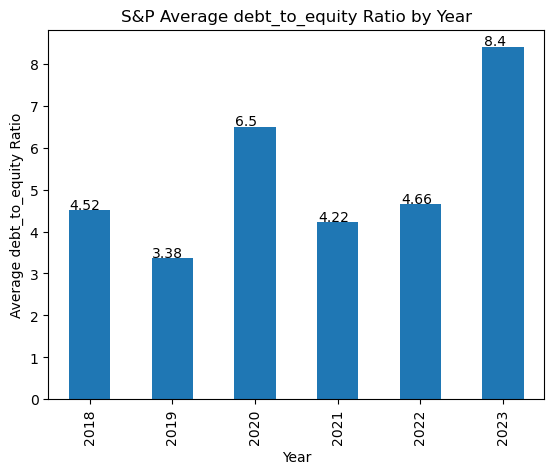

largest 10
    symbol  totalLiabilities  totalShareholderEquity  debt_to_equity
36      BA      1.170200e+11            3.390000e+08      345.191740
242   NCLH      1.848910e+10            6.859100e+07      269.555816
4      ABC      5.711445e+10            2.233540e+08      255.712685
240    MTD      3.467602e+09            2.479300e+07      139.862139
265   ORCL      1.333110e+11            1.073000e+09      124.241379
238    MSI      1.269800e+10            1.160000e+08      109.465517
163    HCA      4.691800e+10            5.720000e+08       82.024476
266   ORLY      1.145638e+10            1.402580e+08       81.680788
164     HD      7.488300e+10            1.562000e+09       47.940461
70      CL      1.492500e+10            4.010000e+08       37.219451
smallest 10
    symbol  totalLiabilities  totalShareholderEquity  debt_to_equity
83    CPRT      6.832650e+08            4.625599e+09        0.147714
20     AMD      1.283000e+10            5.475000e+10        0.234338
147   FSLR 

In [60]:
metric = 'debt_to_equity'
relevant_cols = ['totalLiabilities', 'totalShareholderEquity']
x = relevant_cols[0]
hoover_data = relevant_cols[1:]
# "some financial analysts would treat a negative equity value as a special case and may avoid calculating the Debt-to-Equity ratio at all because the ratio could be misleading"
# summary = summarize_metric(df.copy(), metric, relevant_cols, x, hoover_data)
summary = index_metric_summary(df[df[metric]>0], metric, relevant_cols, x, hoover_data)

# NOTE: something is way off here because the below metrics are around five but this chart is saying its less than 1
# https://ycharts.com/companies/SPGI/debt_equity_ratio

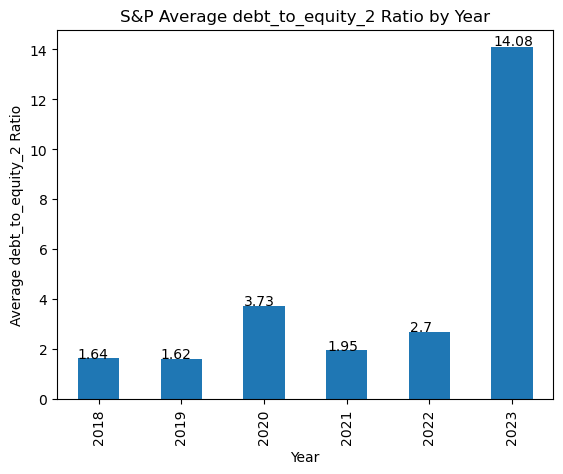

largest 10
    symbol  longTermDebt   currentDebt  totalShareholderEquity  \
265   ORCL  3.583610e+11  4.061000e+09            1.073000e+09   
242   NCLH  1.289113e+10  9.911280e+08            6.859100e+07   
266   ORLY  4.123217e+09  8.273217e+09            1.402580e+08   
240    MTD  1.908480e+09  1.060540e+08            2.479300e+07   
238    MSI  7.638000e+09  1.000000e+06            1.160000e+08   
163    HCA  3.100400e+10  3.370000e+08            5.720000e+08   
36      BA  1.179600e+10  3.190000e+09            3.390000e+08   
4      ABC  6.683924e+09  3.002130e+08            2.233540e+08   
213    LOW  4.244400e+10  1.112000e+09            1.437000e+09   
164     HD  4.115000e+10  1.231000e+09            1.562000e+09   

     debt_to_equity_2  
265        337.765144  
242        202.391801  
266         88.383080  
240         81.254144  
238         65.853448  
163         54.791958  
36          44.206490  
4           31.269362  
213         30.310369  
164         27.132522 

In [61]:
metric = 'debt_to_equity_2'
relevant_cols = ['longTermDebt', 'currentDebt', 'totalShareholderEquity']
x = relevant_cols[0]
hoover_data = relevant_cols[1:]
# "some financial analysts would treat a negative equity value as a special case and may avoid calculating the Debt-to-Equity ratio at all because the ratio could be misleading"
# summary = summarize_metric(df.copy(), metric, relevant_cols, x, hoover_data)
summary = index_metric_summary(df[df[metric]>0], metric, relevant_cols, x, hoover_data)

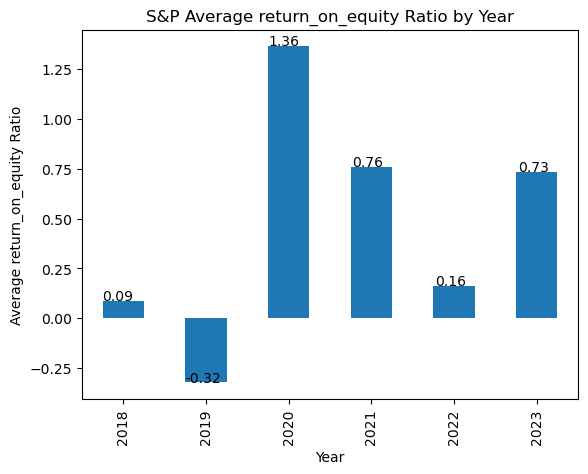

largest 10
    symbol     netIncome  totalShareholderEquity  return_on_equity
248    MTD  8.725020e+08            2.479300e+07         35.191465
275   ORLY  1.752302e+09            1.402580e+08         12.493419
246    MSI  1.363000e+09            1.160000e+08         11.750000
168     HD  1.710500e+10            1.562000e+09         10.950704
274   ORCL  8.503000e+09            1.073000e+09          7.924511
73      CL  1.785000e+09            4.010000e+08          4.451372
193     IT  8.077990e+08            2.277980e+08          3.546120
206    KMB  1.934000e+09            5.470000e+08          3.535649
205   KLAC  3.321807e+09            1.401351e+09          2.370432
231    MCO  1.422000e+09            6.120000e+08          2.323529
smallest 10
    symbol     netIncome  totalShareholderEquity  return_on_equity
250   NCLH -2.269909e+09            6.859100e+07        -33.093394
5      ABC  1.698820e+09           -2.115590e+08         -8.030006
26     AON  2.589000e+09           -5.2

In [62]:
# I think to do this right I'm supposed to average equity
# https://ycharts.com/companies/SPGI/debt_equity_ratio
metric = 'return_on_equity'
relevant_cols = ['netIncome', 'totalShareholderEquity']
x = relevant_cols[0]
hoover_data = relevant_cols[1:]
summary = index_metric_summary(df.copy(), metric, relevant_cols, x, hoover_data)

In [63]:
df.loc['AAPL']

,netIncome,operatingIncome,totalRevenue,commonStockSharesOutstanding,currentDebt,inventory,longTermDebt,totalAssets,totalCurrentAssets,totalCurrentLiabilities,...,industry,price_to_earnings,price_to_earnings_2,debt_to_equity,debt_to_equity_2,return_on_equity,current_ratio,quick_ratio,price_to_sales,price_to_book
end_of_month,,,,,,,,,,,,,,,,,,,,,
2018-09-30,5.953100e+10,7.089800e+10,2.655950e+11,4.754986e+09,2.074800e+10,3.956000e+09,1.119840e+11,3.657250e+11,1.313390e+11,1.159290e+11,...,electronic computers,76.006734,18.030783,2.413301,1.238784,0.555601,1.132926,1.098802,4.041456,10.017924
2019-09-30,5.525600e+10,6.393000e+10,2.565980e+11,4.443236e+09,1.624000e+10,4.106000e+09,1.177600e+11,3.385160e+11,1.628190e+11,1.057180e+11,...,electronic computers,75.157718,18.009837,2.741004,1.480859,0.610645,1.540126,1.501286,3.878251,10.997608
2020-09-30,5.741100e+10,6.628800e+10,2.716420e+11,1.697676e+10,1.379300e+10,4.061000e+09,1.258730e+11,3.238880e+11,1.437130e+11,1.053920e+11,...,electronic computers,35.415902,34.245683,3.957039,2.137559,0.878664,1.363604,1.325072,7.237758,30.090435
2021-09-30,9.468000e+10,1.089490e+11,3.631720e+11,1.642679e+10,1.569200e+10,6.580000e+09,1.187000e+11,3.510020e+11,1.348360e+11,1.254810e+11,...,electronic computers,25.177936,24.549960,4.563512,2.130163,1.500713,1.074553,1.022115,6.400246,36.842451
2022-09-30,9.980300e+10,1.194370e+11,3.913970e+11,1.594342e+10,2.123900e+10,4.946000e+09,1.101000e+11,3.527550e+11,1.354050e+11,1.539820e+11,...,electronic computers,22.618658,22.077306,5.961537,2.591944,1.969589,0.879356,0.847235,5.629530,43.483212


Industry Comparison

In [64]:
# overview_cols = ['symbol', 'sector', 'industry']
# overview_df = pd.read_csv('alphaVantage_data/sp500_overview_2307.csv')
# overview_df.columns = [col.lower() for col in overview_df.columns]

# df.reset_index(inplace=True)
# df = pd.merge(df, overview_df[overview_cols], on='symbol', how='left')
# df['sector'] = df['sector'].str.lower()
# df.to_csv('delete.csv')
# df.head()

In [65]:
df['sector'].value_counts()

manufacturing                 396
life sciences                 346
energy & transportation       345
trade & services              249
technology                    191
finance                        95
real estate & construction     65
Name: sector, dtype: int64

In [66]:
def sector_metric_trend(df, grouping_columns = ['sector', 'year'], y = 'price_to_earnings_2'):
    df.reset_index(inplace=True)
    df['year'] = df['end_of_month'].dt.year

    plot_df = df.groupby(grouping_columns)[y].mean().reset_index()
    
    average_pe_yearly = plot_df.groupby(grouping_columns[1])[y].mean().reset_index()

    # Create the line plot for sectors
    fig = px.line(plot_df, x=grouping_columns[1], y=y, color=grouping_columns[0], 
                title='Average Price to Earnings by Industry and Year', 
                labels={'x':'Year', 'y':'Average Price to Earnings'},
                hover_data=[y])

    # Create the line plot for the yearly average
    average_trace = px.line(average_pe_yearly, x=grouping_columns[1], y=y).data[0]
    average_trace.name = 'Yearly Average'
    average_trace.line = dict(color='black', width=4)
    fig.add_trace(average_trace)

    # Update the layout to add the legend for the yearly average line
    fig.update_layout(
        showlegend=True,
        legend=dict(
            traceorder="reversed",
            title_text='Sector',
            itemsizing='constant'
        )
    )

    fig.show()

sector_metric_trend(df.copy())

In [67]:
sectors = ['technology', 'manufacturing', 'energy & transportation']
mask = df['sector'].isin(sectors)
filtered_df = df[mask]
sector_metric_trend(filtered_df)

C:\Users\grant\AppData\Local\Temp\ipykernel_34432\2873989541.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Trend Analysis

In [77]:
def ticker_metric_trend(df, ticker, metrics, font_size=10):

    ticker_df = df.reset_index()
    ticker_df = ticker_df[ticker_df['symbol'] == ticker]
    ticker_df['Year'] = ticker_df['end_of_month'].dt.year
    
    # Calculate the YoY growth rates for the provided metrics
    for metric in metrics:
        ticker_df[metric + '_YoY'] = ticker_df[metric].pct_change()

    fig = go.Figure()

    for metric in metrics:
        
        fig.add_trace(go.Scatter(x=ticker_df['Year'], y=ticker_df[metric], name=metric,
                                hovertemplate='Year: %{x}<br>' + metric + ': %{y}<br>' + metric + ' YoY Growth: %{customdata}',
                                customdata=ticker_df[metric + '_YoY']))
    
        # Add annotations for YoY growth rates
        for i in range(len(ticker_df)):
            fig.add_annotation(
                x=ticker_df['Year'].iloc[i],
                y=ticker_df[metric].iloc[i],
                text=f"{ticker_df[metric].iloc[i]/1e9:.2f} B<br>({ticker_df[metric + '_YoY'].iloc[i]:.2%})",
                showarrow=False,
                font=dict(size=font_size),
                xshift=font_size,
                # given it contains the value and percent change stacked
                yshift=font_size * 2
            )
    
    # Update x axis to only show integer years, was showing half values prior
    fig.update_xaxes(
        tickmode = 'array',
        tickvals = ticker_df['Year']
    )

    fig.update_layout(title=f'Yearly Trends for {ticker }',
                    xaxis_title='Year',
                    yaxis_title='Amount (in $)',
                    hovermode='x')

    # Show the figure
    fig.show()

ticker_metric_trend(df.reset_index(), ticker='AAPL', metrics=['totalRevenue', 'netIncome'])

In [79]:
ticker_metric_trend(df.reset_index(), ticker='AAPL', metrics=['totalAssets', 'totalLiabilities', 'totalShareholderEquity'])

In [80]:
def index_metric_trend(df, tickers, metric, font_size=10):

    fig = go.Figure()

    avg_metric = pd.DataFrame() 

    for ticker in tickers:
        ticker_df = df.reset_index()
        ticker_df = ticker_df[ticker_df['symbol'] == ticker]
        ticker_df['Year'] = ticker_df['end_of_month'].dt.year

        ticker_df[metric + '_YoY'] = ticker_df[metric].pct_change()

        avg_metric = pd.concat([avg_metric, ticker_df[[metric, 'Year', metric + '_YoY']]], ignore_index=True)
        
        fig.add_trace(go.Scatter(x=ticker_df['Year'], y=ticker_df[metric], name=ticker,
                                hovertemplate='Ticker: ' + ticker + '<br>Year: %{x}<br>' + metric + ': %{y}<br>' + metric + ' YoY Growth: %{customdata}',
                                customdata=ticker_df[metric + '_YoY']))

    # Calculate and add average trend line
    avg_metric = avg_metric.groupby('Year').mean().reset_index()

    fig.add_trace(go.Scatter(x=avg_metric['Year'], y=avg_metric[metric], name='Average',
                            hovertemplate='Average<br>Year: %{x}<br>' + metric + ': %{y}<br>' + metric + ' YoY Growth: %{customdata}',
                            customdata=avg_metric[metric + '_YoY'], line=dict(color='firebrick', width=4, dash='dash')))

    # Add annotations for the average line
    for i in range(len(avg_metric)):
        fig.add_annotation(
            x=avg_metric['Year'].iloc[i],
            y=avg_metric[metric].iloc[i],
            text=f"{avg_metric[metric].iloc[i]/1e9:.2f} B<br>({avg_metric[metric + '_YoY'].iloc[i]:.2%})</b>",
            showarrow=False,
            # font=dict(size=font_size * 1.5, color='white'),  # Increase size and change color to white
            font=dict(size=font_size , color='white'),  # Increase size and change color to white
            bgcolor='black',  # Add black background color
            xshift=font_size,
            # yshift=font_size * 2
            yshift=0
        )

    fig.update_xaxes(
        tickmode = 'array',
        tickvals = ticker_df['Year']
    )

    fig.update_layout(title=f'Yearly Trends for {metric}',
                    xaxis_title='Year',
                    yaxis_title='Amount (in $)',
                    # hovermode='x')
                    hovermode='closest')

    fig.show()

In [81]:
# matana = ['MSFT', 'AAPL', 'TSLA', 'GOOGL', 'NVDA', 'AMZN']
matana = ['MSFT', 'AAPL', 'TSLA', 'GOOGL', 'AMZN']
index_metric_trend(df.reset_index(), tickers=matana, metric='totalRevenue')

In [72]:
index_metric_trend(df.reset_index(), tickers=matana, metric='netIncome')

In [73]:
index_metric_trend(df.reset_index(), tickers=matana, metric='price_to_earnings_2')

In [74]:
index_metric_trend(df.reset_index(), tickers=matana, metric='return_on_equity')

# Cash Flow Analysis

Understand the Types of Cash Flows: Cash flows in a company are typically categorized into three types:

- Operating Cash Flow: This represents the cash generated from a company's normal business operations. It's a good measure of a company's operational efficiency and financial health. A consistently positive operating cash flow is a good sign.

- Investing Cash Flow: This represents the cash used for investing in the business, such as purchasing equipment or investing in other companies. It can also include cash received from selling investments.

- Financing Cash Flow: This represents the cash transactions between the company and its owners and creditors - issuing or buying back shares, paying out dividends, or borrowing and repaying debt.

A company with steadily increasing operating cash flow and controlled investing and financing cash flows is generally considered to be in good financial health.

In [84]:
# cf_metrics = ['cashflowFromFinancing', 'cashflowFromInvestment', 'operatingCashflow'
#             , 'capitalExpenditures']
cf_metrics = ['cashflowFromFinancing', 'cashflowFromInvestment', 'operatingCashflow']
ticker_metric_trend(df.reset_index(), ticker='AAPL', metrics=cf_metrics)

Compare Cash Flow to Net Income: Net income includes non-cash items and can be manipulated by changing accounting policies. Therefore, comparing cash flow from operations with net income can give you a sense of the quality of a company's earnings. If the cash flow from operations consistently exceeds net income, earnings are considered high-quality.

In [87]:
cf_metrics = ['netIncome', 'operatingCashflow']
ticker_metric_trend(df.reset_index(), ticker='AAPL', metrics=cf_metrics)

Consider Free Cash Flow: Free cash flow is the cash a company generates from its operations minus the capital expenditures (money spent on property, plant, and equipment). This is the cash that can be used for expansion, paying down debt, paying dividends, or other purposes. A positive free cash flow is a good sign of financial health.

In [91]:
ticker_metric_trend(df.reset_index(), ticker='AAPL', metrics=['free_cash_flow'])

NOTE: look into some cf metrics/ratios

# Valuation

We're going to do an extremely simplified Discounted Cash Flow (DCF):

- Forecast Free Cash Flows: We'll assume the free cash flows grow at current trend for the next five years.

- Calculate Terminal Value: After the forecast period, we'll forecast terminal value using the Gordon Growth Model (which assumes that free cash flows will grow at a constant rate indefinitely)

- Discount Back to Present Value: The final step is to discount the forecasted free cash flows and the terminal value back to the present value using a discount rate. The discount rate should reflect the riskiness of the cash flows. Typically, the company's Weighted Average Cost of Capital (WACC) is used as the discount rate.

In [113]:
def dcf_model(df, symbol, forecast_period=5, wacc=.1, terminal_growth_rate=.025):
    # Extract the data for the specified symbol
    df_symbol = df.loc[symbol]
    
    # Calculate the current growth rate of free cash flow
    current_growth_rate = df_symbol['free_cash_flow'].pct_change().mean()
    
    # Forecast the Free Cash Flows for the next years
    fcf = df_symbol['free_cash_flow'].iloc[-1]
    forecasted_fcf = [fcf * ((1 + current_growth_rate) ** i) for i in range(1, forecast_period + 1)]
    
    # Calculate the Terminal Value
    terminal_value = forecasted_fcf[-1] * (1 + terminal_growth_rate) / (wacc - terminal_growth_rate)
    
    # Discount the forecasted FCFs and the Terminal Value back to the present value
    discounted_fcf = [fcf / ((1 + wacc) ** i) for i, fcf in enumerate(forecasted_fcf, start=1)]
    discounted_terminal_value = terminal_value / ((1 + wacc) ** forecast_period)
    
    # Sum up the present value of forecasted FCFs and Terminal Value
    intrinsic_value = sum(discounted_fcf) + discounted_terminal_value
    
    # Determine the scale based on the max cash flow value
    max_value = max(max(forecasted_fcf), terminal_value)
    if max_value >= 1e9:
        scale = 1e9
        label = 'B'
    elif max_value >= 1e6:
        scale = 1e6
        label = 'M'
    else:
        scale = 1e3
        label = 'K'
    
    # Scale the cash flows for the plot and table
    actual_cash_flows = (df_symbol['free_cash_flow'] / scale).tolist()
    forecasted_fcf = [fcf / scale for fcf in forecasted_fcf]
    terminal_value /= scale
    discounted_fcf = [fcf / scale for fcf in discounted_fcf]
    discounted_terminal_value /= scale
    
    # Extract the years from the 'end_of_month' column for the actual data
    actual_years = df_symbol.index.year.tolist()
    forecasted_years = list(range(actual_years[-1] + 1, actual_years[-1] + forecast_period + 1))
    
    # Create a plot for actual and forecasted cash flows
    plt.figure(figsize=(10, 6))
    bars1 = plt.bar(actual_years, actual_cash_flows, color='b', label='Actual')
    bars2 = plt.bar(forecasted_years, forecasted_fcf, color='r', label='Forecast')
    
    # Adding value labels on top of each bar
    for bars in [bars1, bars2]:
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval,
                    '{:,.1f}'.format(yval), ha='center', va='bottom')
    
    plt.xlabel('Year')
    plt.ylabel(f'Cash Flow ({label})')
    plt.legend()
    plt.show()
    
    # Create a table for the forecasted cash flows
    df_table = pd.DataFrame({
        'Year': forecasted_years + ['Terminal'],
        'Undiscounted Cash Flow': forecasted_fcf + [terminal_value],
        'Discounted Cash Flow': discounted_fcf + [discounted_terminal_value]
    })

    # Append total row
    df_table = df_table.append({
        'Year': 'Total',
        'Undiscounted Cash Flow': df_table['Undiscounted Cash Flow'].sum(),
        'Discounted Cash Flow': df_table['Discounted Cash Flow'].sum()
    }, ignore_index=True)

    # Add a column for the percent contribution to the total intrinsic value
    df_table['% Contribution to Intrinsic Value'] = df_table['Discounted Cash Flow'] / df_table['Discounted Cash Flow'].iloc[-1] * 100
    
    # Formatting the numbers for better readability
    df_table['Undiscounted Cash Flow'] = df_table['Undiscounted Cash Flow'].apply(lambda x: '{:,.1f}'.format(x))
    df_table['Discounted Cash Flow'] = df_table['Discounted Cash Flow'].apply(lambda x: '{:,.1f}'.format(x))
    df_table['% Contribution to Intrinsic Value'] = df_table['% Contribution to Intrinsic Value'].apply(lambda x: '{:,.1f}%'.format(x))
    
    print(df_table)
    
    return intrinsic_value


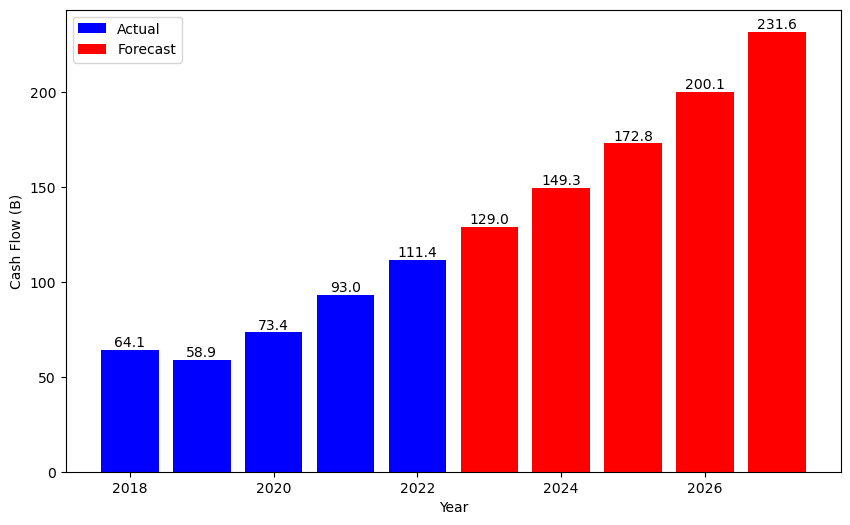

       Year Undiscounted Cash Flow Discounted Cash Flow  \
0      2023                  129.0                117.3   
1      2024                  149.3                123.4   
2      2025                  172.8                129.9   
3      2026                  200.1                136.6   
4      2027                  231.6                143.8   
5  Terminal                3,164.9              1,965.2   
6     Total                4,047.7              2,616.1   

  % Contribution to Intrinsic Value  
0                              4.5%  
1                              4.7%  
2                              5.0%  
3                              5.2%  
4                              5.5%  
5                             75.1%  
6                            100.0%  


C:\Users\grant\AppData\Local\Temp\ipykernel_34432\1468992129.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



'2,616,148,989,449'

In [119]:
symbol = "AAPL"
intrinsic_value = dcf_model(df.copy(), symbol=symbol)
"{:,}".format(int(intrinsic_value))

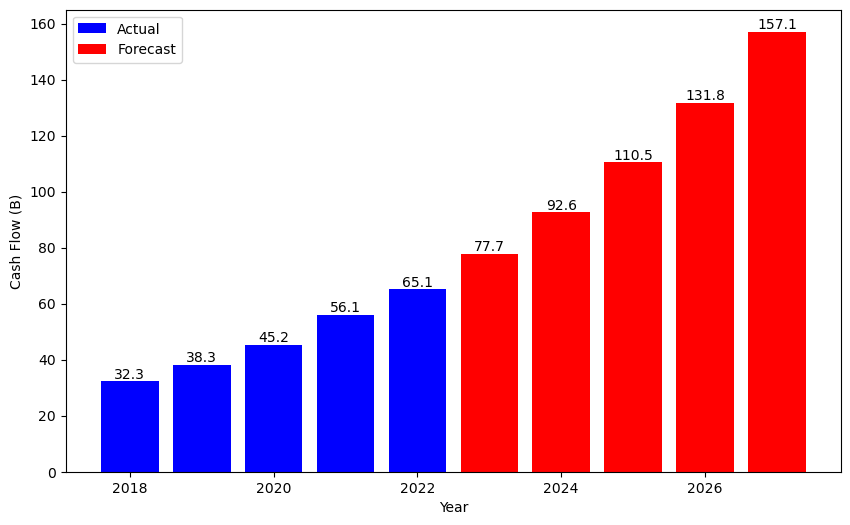

       Year Undiscounted Cash Flow Discounted Cash Flow  \
0      2023                   77.7                 70.6   
1      2024                   92.6                 76.6   
2      2025                  110.5                 83.0   
3      2026                  131.8                 90.0   
4      2027                  157.1                 97.6   
5  Terminal                2,147.4              1,333.4   
6     Total                2,717.1              1,751.1   

  % Contribution to Intrinsic Value  
0                              4.0%  
1                              4.4%  
2                              4.7%  
3                              5.1%  
4                              5.6%  
5                             76.1%  
6                            100.0%  


C:\Users\grant\AppData\Local\Temp\ipykernel_34432\1468992129.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



'1,751,125,305,376'

In [122]:
symbol = "MSFT"
intrinsic_value = dcf_model(df.copy(), symbol=symbol)
"{:,}".format(int(intrinsic_value))